# Currency Pairs Trading Engine (FX Cointegration Stat-Arb)

This notebook is an end-to-end research + backtesting pipeline for FX Pairs trading:

- **Note**: This project is a fun research I conducted in my free time to improve my knowledge of FX Markets, coding and researching.
-  **Data**: Alpha Vantage 'FX_DAILY'
- **Backtest**: single-timeline backtester with **rolling refits**, **purge**, **stateful positions**, and **turnover-based transaction costs**
- **Robustness**: cost sensitivity + parameter sweep (cooldown, vol targeting, smoothed hedge ratio)

### 0. Setup

Requirements in your venv:
- `pandas`, `numpy`, `statsmodels`, `matplotlib`, `requests`, `python-dotenv`, `pyarrow` (for Parquet)

Your Alpha Vantage key should be in a `.env` file in the project root:

```
ALPHAVANTAGE_API_KEY=YOUR_KEY
```

**Note on rate limits** Please understand that Alpha Vantage is rate-limited.

In [1]:
from pathlib import Path
import os, time, json
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt

load_dotenv()
AV_KEY = os.getenv("ALPHAVANTAGE_API_KEY")
if not AV_KEY:
    raise RuntimeError("Please ensure your Alphavantage Api Key is in your .env file for this code to run")


In [2]:
# Project Paths
PROJECT_ROOT = Path(".")
DATA_RAW = Path("data_raw")
DATA_RAW.mkdir(exist_ok=True)
CACHE_DIR = DATA_RAW / "alphavantage_fx_daily"
CACHE_DIR.mkdir(exist_ok=True)
REPORTS_DIR = PROJECT_ROOT / "reports"

AV_URL = "https://www.alphavantage.co/query"

START_DATE = pd.Timestamp("2016-01-01") #We define the start date for 10 years worth of data

In [ ]:
import sys 
print(sys.executable) #To check if we are in our virtual environment or not
print('If this is not your project .venv python, switch the Jupyter kernel to your venv.')

/Users/lvsreenivaas/Desktop/fx_pairs_trading/.venv/bin/python


## 1) Data Loading (Alpha Vantage)

We download `FX_DAILY` OHLC and cache each pair to Parquet:

- First run: downloads + caches
- Next runs: reads from cache (fast)

If you see a rate limit message, then please wait and rerun later. We cache it so that we do not receive rate limit messages when we run the cells again.

In [4]:

def fetch_fx_daily(from_ccy: str, to_ccy: str, outputsize="full") -> pd.DataFrame:
    params = {
        "function": "FX_DAILY",
        "from_symbol": from_ccy,
        "to_symbol": to_ccy,
        "outputsize": outputsize,
        "datatype": "json",
        "apikey": AV_KEY,
    }
    r = requests.get(AV_URL, params=params, timeout=30)
    data = r.json()

    if "Error Message" in data:
        raise RuntimeError(data["Error Message"])
    if "Note" in data:
        # Rate limit message
        raise RuntimeError(f"Rate limit: {data['Note']}")

    ts_key = next((k for k in data.keys() if "Time Series" in k), None)
    if not ts_key:
        raise RuntimeError(f"Unexpected response keys: {list(data.keys())[:10]}")

    ts = data[ts_key]
    df = (
        pd.DataFrame.from_dict(ts, orient="index")
        .rename(columns={"1. open":"open","2. high":"high","3. low":"low","4. close":"close"})
        .astype(float)
        .reset_index()
        .rename(columns={"index":"date"})
    )
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")
    df["pair"] = f"{from_ccy}{to_ccy}"
    return df

def load_or_fetch_pair(from_ccy: str, to_ccy: str, outputsize="full", pause_s=12.5) -> pd.DataFrame:

    fname = f"{from_ccy}{to_ccy}_daily.csv"
    path = CACHE_DIR / fname
    if path.exists():
        return pd.read_csv(path, parse_dates=["date"])

    df = fetch_fx_daily(from_ccy, to_ccy, outputsize=outputsize)
    df.to_csv(path, index=False)
    time.sleep(pause_s) 
    return df


def build_price_panel(universe: dict[str, tuple[str, str]], start_date: pd.Timestamp = START_DATE) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Return (prices, log_prices) aligned to business days and restricted to start_date."""
    series: dict[str, pd.Series] = {}

    for name, (a, b) in universe.items():
        try:
            df = load_or_fetch_pair(a, b, outputsize="full")
            df["date"] = pd.to_datetime(df["date"])
            df = df[df["date"] >= start_date].copy()  # guardrail

            s = df.set_index("date")["close"].astype(float).sort_index()
            series[name] = s
            print(f"OK  {name:7s}  {s.index.min().date()} → {s.index.max().date()}  n={len(s)}")
        except Exception as e:
            print(f"FAIL {name:7s} : {e}")

    prices = pd.concat(series.values(), axis=1)
    prices.columns = list(series.keys())

    # align to business days
    prices = prices.asfreq("B").ffill(limit=3)

    # final guardrail
    prices = prices.loc[start_date:].copy()

    logp = np.log(prices).dropna(how="any")
    return prices, logp


## 2) Define the FX universe

I have chosen the following pairs of currencies based on the following factors : 

1. Liquidity & Data Quality : These pairs are widely quoted and traded with readily available price history, therefore our data issues are minimal at best
2. Economic Links : We are choosing clusters where co-movement is possible:
- USD vs major EM currencies (INR, MXN, BRL, COP, CLP, PEN, KRW, ZAR): often driven by global USD/risk/commodity forces.
- USDCNY vs USDCNH: same Chinese yuan, but onshore vs offshore markets — a useful “control” pair.
- Major G10 + European crosses (EURUSD, GBPUSD, AUDUSD, NZDUSD, USDCAD, EURGBP, EURCHF, EURSEK, EURNOK, USDNOK): liquid benchmarks and regional linkages.

In [5]:
universe = {
    "USDINR": ("USD","INR"),
    "USDMXN": ("USD","MXN"),
    "USDBRL": ("USD","BRL"),
    "USDCOP": ("USD","COP"),
    "USDCLP": ("USD","CLP"),
    "USDPEN": ("USD","PEN"),
    "USDKRW": ("USD","KRW"),
    "USDCNY": ("USD","CNY"),
    "USDCNH": ("USD","CNH"),
    "EURGBP": ("EUR","GBP"),
    "EURUSD": ("EUR","USD"),
    "GBPUSD": ("GBP","USD"),
    "AUDUSD": ("AUD","USD"),
    "NZDUSD": ("NZD","USD"),
    "USDCAD": ("USD","CAD"), 
    "USDZAR": ("USD","ZAR"),  
    "USDNOK": ("USD","NOK"),
    "EURCHF": ("EUR","CHF"),  
    "EURSEK": ("EUR","SEK"),  
    "EURNOK": ("EUR","NOK"),  
    
}

In [6]:

series = {}

for name, (a, b) in universe.items():
    try:
        df = load_or_fetch_pair(a, b, outputsize="full")
        df["date"] = pd.to_datetime(df["date"])

        df = df[df["date"] >= START_DATE].copy()

        s = df.set_index("date")["close"].astype(float).sort_index()
        series[name] = s
        print(name, s.index.min().date(), "to", s.index.max().date(), "Total Dates", len(s))
    except Exception as e:
        print("FAIL", name, ":", e)

prices = pd.concat(series.values(), axis=1)
prices.columns = list(series.keys())

prices = prices.asfreq("B").ffill(limit=3).dropna(how="all")

prices = prices.loc[START_DATE:].copy()

logp = np.log(prices).dropna()
logp.head()


USDINR 2016-01-01 to 2026-01-02 Total Dates 2611
USDMXN 2016-01-01 to 2026-01-02 Total Dates 2611
USDBRL 2016-01-01 to 2026-01-02 Total Dates 2608
USDCOP 2016-01-01 to 2026-01-02 Total Dates 2608
USDCLP 2016-01-04 to 2026-01-02 Total Dates 2601
USDPEN 2016-01-01 to 2026-01-02 Total Dates 2601
USDKRW 2016-01-01 to 2026-01-02 Total Dates 2611
USDCNY 2016-01-01 to 2026-01-05 Total Dates 2535
USDCNH 2016-01-01 to 2026-01-02 Total Dates 2611
EURGBP 2016-01-01 to 2026-01-02 Total Dates 2611
EURUSD 2016-01-01 to 2026-01-02 Total Dates 2611
GBPUSD 2016-01-01 to 2026-01-02 Total Dates 2611
AUDUSD 2016-01-01 to 2026-01-02 Total Dates 2611
NZDUSD 2016-01-01 to 2026-01-02 Total Dates 2611
USDCAD 2016-01-04 to 2026-01-02 Total Dates 2610
USDZAR 2016-01-01 to 2026-01-02 Total Dates 2610
USDNOK 2016-01-01 to 2026-01-02 Total Dates 2607
EURCHF 2016-01-01 to 2026-01-02 Total Dates 2611
EURSEK 2016-01-01 to 2026-01-02 Total Dates 2610
EURNOK 2016-01-01 to 2026-01-02 Total Dates 2610


,USDINR,USDMXN,USDBRL,USDCOP,USDCLP,USDPEN,USDKRW,USDCNY,USDCNH,EURGBP,EURUSD,GBPUSD,AUDUSD,NZDUSD,USDCAD,USDZAR,USDNOK,EURCHF,EURSEK,EURNOK
date,,,,,,,,,,,,,,,,,,,,
2016-01-04,4.198014,2.850510,1.396393,8.075925,6.574867,1.226566,7.082129,1.876989,1.891182,-0.306797,0.079606,0.386323,-0.331383,-0.393220,0.331259,2.743797,2.183224,0.081792,2.219024,2.262337
2016-01-05,4.197247,2.851723,1.393717,8.073808,6.569481,1.228470,7.081583,1.875166,1.893925,-0.311074,0.072544,0.383506,-0.334103,-0.400239,0.335035,2.749314,2.186400,0.080981,2.222799,2.258843
2016-01-06,4.200340,2.864341,1.392152,8.087640,6.571723,1.228763,7.089993,1.880152,1.901704,-0.305887,0.074588,0.380195,-0.347503,-0.410257,0.342000,2.763138,2.192237,0.082068,2.224786,2.266989
2016-01-07,4.203199,2.880187,1.397482,8.092637,6.581194,1.228177,7.084059,1.887039,1.899791,-0.292239,0.088102,0.380284,-0.354249,-0.411765,0.345000,2.777427,2.183678,0.082160,2.224555,2.271875
2016-01-08,4.201928,2.885175,1.397729,8.090280,6.588789,1.230225,7.096142,1.885857,1.899268,-0.284886,0.087947,0.373018,-0.363642,-0.424571,0.348634,2.790306,2.180864,0.082777,2.228527,2.271347


### Quick visualization: normalized prices

Plot a few series normalized to 100 at the start date (for sanity).


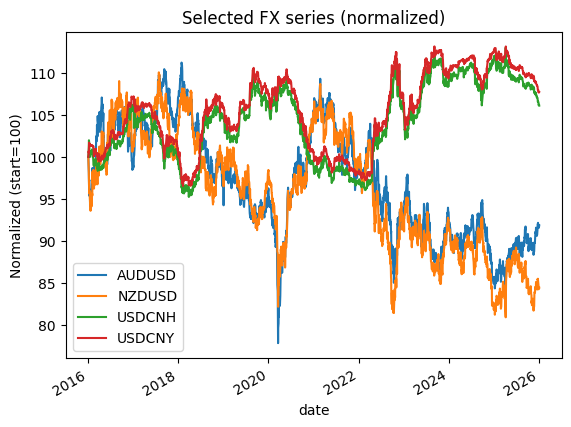

In [7]:
def plot_normalized(prices: pd.DataFrame, cols: list[str], title: str):
    base = prices[cols].dropna().iloc[0]
    norm = 100 * prices[cols].dropna() / base
    ax = norm.plot(title=title)
    ax.set_ylabel("Normalized (start=100)")
    plt.show()

plot_normalized(prices, ["AUDUSD", "NZDUSD", "USDCNH", "USDCNY"], "Selected FX series (normalized)")


## 3) Cointegration screening (Engle–Granger)

For each currency pair we perform the following procedure:

1. Fit OLS: $Y_t = \alpha + \beta X_t + \epsilon_t$
2. Test cointegration via Engle–Granger (`coint`)
3. Test residual stationarity via ADF (`adfuller`)
4. Estimate half-life of mean reversion from an AR(1) approximation on residuals

> Screening is a *starting point*, not proof of profitability.

In [8]:

MIN_OVERLAP = 1200 

def half_life_from_resid(resid: pd.Series) -> float:
    s = resid.dropna()
    if len(s) < 80:
        return float("nan")
    ds = s.diff().dropna()
    lag = s.shift(1).dropna().loc[ds.index]
    m = sm.OLS(ds, sm.add_constant(lag)).fit()
    gamma = float(m.params.iloc[1])  # ΔS = gamma*S_{t-1} + e
    return float(-np.log(2)/gamma) if gamma < 0 else float("inf")

def eg_test(y: pd.Series, x: pd.Series):
    df = pd.concat([y,x], axis=1).dropna()
    if len(df) < MIN_OVERLAP:
        return None
    y2, x2 = df.iloc[:,0], df.iloc[:,1]
    m = sm.OLS(y2, sm.add_constant(x2)).fit()
    alpha = float(m.params.iloc[0]); beta = float(m.params.iloc[1])
    resid = y2 - (alpha + beta*x2)
    return {
        "alpha": alpha,
        "beta": beta,
        "p_coint": float(coint(y2, x2)[1]),
        "p_adf": float(adfuller(resid.dropna())[1]),
        "half_life_days": half_life_from_resid(resid),
        "nobs": len(df),
    }

rows = []
cols = list(logp.columns)

for a, b in itertools.combinations(cols, 2):
    r1 = eg_test(logp[a], logp[b])
    r2 = eg_test(logp[b], logp[a])
    if r1 is None and r2 is None:
        continue
    # keep direction with smaller cointegration p-value
    if r2 is None or (r1 is not None and r1["p_coint"] <= r2["p_coint"]):
        best = r1; y_name, x_name = a, b
    else:
        best = r2; y_name, x_name = b, a

    rows.append({"Y": y_name, "X": x_name, **best})

results = pd.DataFrame(rows).sort_values(["p_coint","p_adf","half_life_days"])
results.head(20)

,Y,X,alpha,beta,p_coint,p_adf,half_life_days,nobs
112,USDCNH,USDCNY,-0.012449,1.006677,6.584011e-14,4.867805e-15,1.880368,2596
145,GBPUSD,EURUSD,0.171944,0.783894,5.135566e-05,6.361600e-06,49.461882,2596
135,EURGBP,EURUSD,-0.172167,0.216372,5.264820e-05,6.532529e-06,49.539643,2596
88,EURGBP,USDPEN,-0.022993,-0.098698,5.692130e-05,7.128024e-06,48.974902,2596
142,EURGBP,EURCHF,-0.152285,0.102551,6.036350e-05,7.590430e-06,49.300715,2596
101,EURGBP,USDKRW,0.460532,-0.085581,6.140431e-05,7.731472e-06,48.495851,2596
74,EURGBP,USDCLP,0.129087,-0.041615,6.734385e-05,8.531126e-06,49.467374,2596
118,USDCAD,USDCNY,-1.036996,0.685586,7.798930e-05,9.955973e-06,36.764431,2596
140,EURGBP,USDZAR,-0.030848,-0.042488,8.656119e-05,1.115890e-05,49.845699,2596
141,EURGBP,USDNOK,-0.069497,-0.035192,9.879801e-05,1.285588e-05,50.878596,2596


## 4) Pair diagnostics

We’ll inspect two pairs:

- **USDCNH vs USDCNY** — selected because it ranks #1 in our screen (**strongest cointegration + most stationary residual**) and shows **fast mean reversion** (≈2-day half-life), making it a practical daily mean‑reversion case study.


- AUDUSD vs NZDUSD — a common FX benchmark pair used as a baseline comparison.

We’ll visualize:

- normalized prices

- residual spread 

- z-score of the spread (signal)

Pair: USDCNH ~ USDCNY
alpha: -0.01244875963395009 beta: 1.0066770862190233 R2: 0.9971703951535787
Engle-Granger p: 6.584011455738366e-14
ADF p(resid): 4.867804634070879e-15
Half-life: 1.8803680870350472


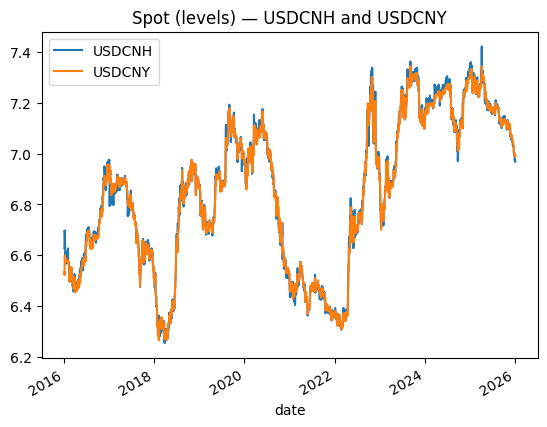

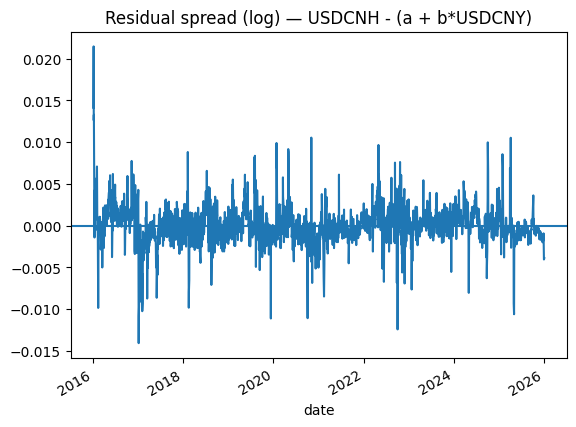

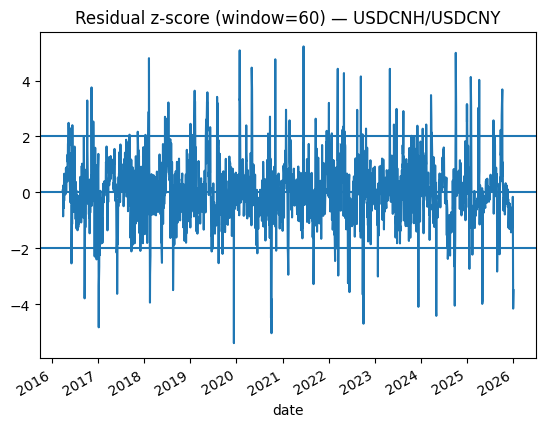

In [9]:
def diagnostics_pair(logp: pd.DataFrame, y: str, x: str, z_window: int = 60):
    df = logp[[y, x]].dropna().copy()
    m = sm.OLS(df[y], sm.add_constant(df[x])).fit()
    a = float(m.params.iloc[0]); b = float(m.params.iloc[1])
    resid = df[y] - (a + b*df[x])

    z = (resid - resid.rolling(z_window).mean()) / resid.rolling(z_window).std(ddof=0)

    print(f"Pair: {y} ~ {x}")
    print("alpha:", a, "beta:", b, "R2:", float(m.rsquared))
    print("Engle-Granger p:", float(coint(df[y], df[x])[1]))
    print("ADF p(resid):", float(adfuller(resid.dropna())[1]))
    print("Half-life:", half_life_from_resid(resid))

    # plots
    (np.exp(df[[y,x]])).plot(title=f"Spot (levels) — {y} and {x}")
    plt.show()

    resid.plot(title=f"Residual spread (log) — {y} - (a + b*{x})")
    plt.axhline(0)
    plt.show()

    z.plot(title=f"Residual z-score (window={z_window}) — {y}/{x}")
    plt.axhline(2); plt.axhline(-2); plt.axhline(0)
    plt.show()

    return a, b, resid, z

a1, b1, resid_cnhcny, z_cnhcny = diagnostics_pair(logp, "USDCNH", "USDCNY", z_window=60)


Pair: AUDUSD ~ NZDUSD
alpha: 0.011899082358207094 beta: 0.8518440783956103 R2: 0.9138357617317655
Engle-Granger p: 0.010841192486818151
ADF p(resid): 0.0022601258713671633
Half-life: 54.16056637663938


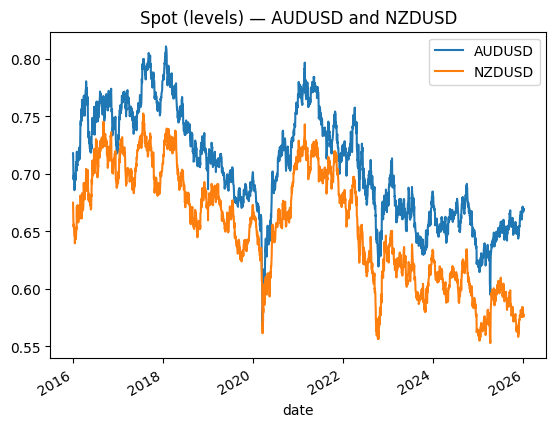

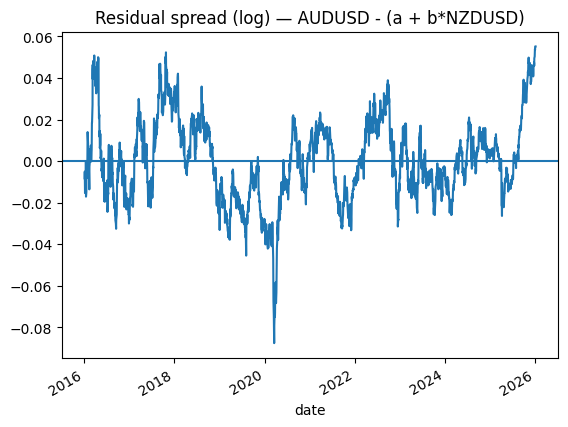

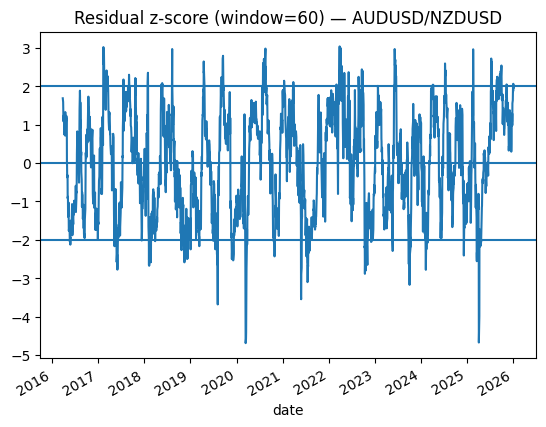

In [10]:
a2, b2, resid_audnzd, z_audnzd = diagnostics_pair(logp, "AUDUSD", "NZDUSD", z_window=60)


## 5) Backtest (single-timeline, rolling refits + purge + costs)

Key rules:
- Refit hedge ratio every `step_days` using prior `train_days` (purged by `purge_days`)
- Compute residual today using latest hedge ratio
- Compute z-score using **past** residuals only (no lookahead)
- Trade mean reversion: enter at ±entry_z, exit when |z| < exit_z
- Costs: turnover-based (both legs), `cost_bps` in basis points


In [11]:
def pairs_backtest_single_timeline(
    logp: pd.DataFrame,
    y: str,
    x: str,
    train_days: int = 252*2,
    purge_days: int = 5,
    step_days: int = 21,
    z_window: int = 60,
    entry_z: float = 2.0,
    exit_z: float = 0.5,
    cost_bps: float = 3.0,
):
    df = logp[[y, x]].dropna().copy()
    n = len(df)

    alpha = np.full(n, np.nan)
    beta  = np.full(n, np.nan)
    resid = np.full(n, np.nan)
    z     = np.full(n, np.nan)
    pos   = np.zeros(n)

    state = 0.0
    last_refit = None

    start = train_days + purge_days

    for t in range(start, n):
        
        if (last_refit is None) or ((t - last_refit) >= step_days):
            train = df.iloc[t - purge_days - train_days : t - purge_days]
            m = sm.OLS(train[y], sm.add_constant(train[x])).fit()
            a = float(m.params.iloc[0])
            b = float(m.params.iloc[1])
            last_refit = t

        alpha[t] = a
        beta[t]  = b

        # residual today
        yt = float(df[y].iloc[t])
        xt = float(df[x].iloc[t])
        resid[t] = yt - (a + b * xt)

        # z-score using strictly past residuals
        if t >= start + z_window:
            window = resid[t - z_window : t]
            mu = np.nanmean(window)
            sd = np.nanstd(window)
            if sd > 0:
                z[t] = (resid[t] - mu) / sd

        zz = z[t]
        if np.isnan(zz):
            pos[t] = state
            continue

        if state == 0.0:
            if zz > entry_z:
                state = -1.0
            elif zz < -entry_z:
                state = 1.0
        else:
            if abs(zz) < exit_z:
                state = 0.0

        pos[t] = state

    out = pd.DataFrame(
        {"alpha": alpha, "beta": beta, "resid": resid, "z": z, "pos": pos},
        index=df.index
    ).dropna(subset=["beta"])

    out["wy"] = out["pos"]
    out["wx"] = -out["beta"] * out["pos"]

    out["ry"] = df[y].diff()
    out["rx"] = df[x].diff()

    out["gross"] = (out["wy"].shift(1) * out["ry"]) + (out["wx"].shift(1) * out["rx"])
    out["gross"] = out["gross"].fillna(0.0)

    out["turnover"] = (out["wy"].diff().abs().fillna(0.0) + out["wx"].diff().abs().fillna(0.0))
    out["cost"] = (cost_bps / 1e4) * out["turnover"]
    out["pnl"] = out["gross"] - out["cost"]

    pnl = out["pnl"].dropna()
    sharpe = np.sqrt(252) * pnl.mean() / (pnl.std(ddof=0) + 1e-12)
    tstat  = pnl.mean() / (pnl.std(ddof=0) / np.sqrt(len(pnl)) + 1e-12)

    summary = pd.Series({
        "start": pnl.index.min().date(),
        "end": pnl.index.max().date(),
        "n_days": int(len(pnl)),
        "Sharpe_net": float(sharpe),
        "t_stat_net": float(tstat),
        "avg_daily_turnover": float(out["turnover"].mean()),
        "pct_in_market": float((out["pos"].abs() > 0).mean()),
        "pct_|z|>entry": float((out["z"].abs() > entry_z).mean()),
    })

    return summary, out


In [12]:
# Baseline paramaters we can adjust as necessary
BASE = dict(train_days=252*2, purge_days=5, step_days=21, z_window=60, entry_z=2.0, exit_z=0.5, cost_bps=4.0)

s_cnhcny, df_cnhcny = pairs_backtest_single_timeline(logp, "USDCNH", "USDCNY", **BASE)
s_audnzd, df_audnzd = pairs_backtest_single_timeline(logp, "AUDUSD", "NZDUSD", **BASE)

print("USDCNH–USDCNY\n", s_cnhcny.to_string())
print("\nAUDUSD–NZDUSD\n", s_audnzd.to_string())


USDCNH–USDCNY
 start                 2017-12-15
end                   2026-01-05
n_days                      2087
Sharpe_net              1.305621
t_stat_net              3.757319
avg_daily_turnover      0.143567
pct_in_market           0.167226
pct_|z|>entry           0.068519

AUDUSD–NZDUSD
 start                 2017-12-15
end                   2026-01-05
n_days                      2087
Sharpe_net              0.136743
t_stat_net              0.393519
avg_daily_turnover      0.072401
pct_in_market           0.441303
pct_|z|>entry           0.148059


### Plot cumulative PnL and z-score

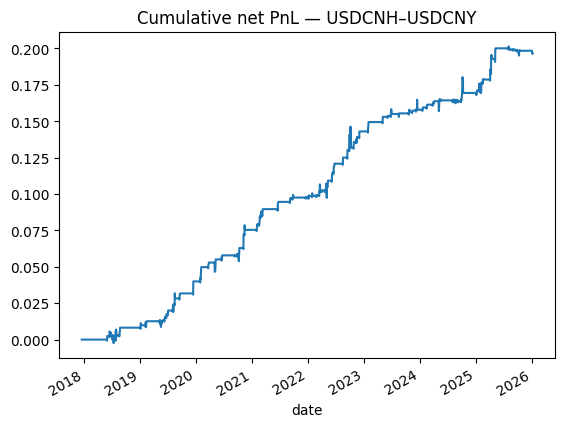

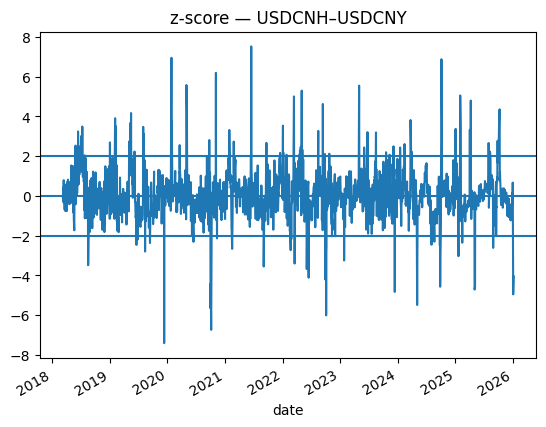

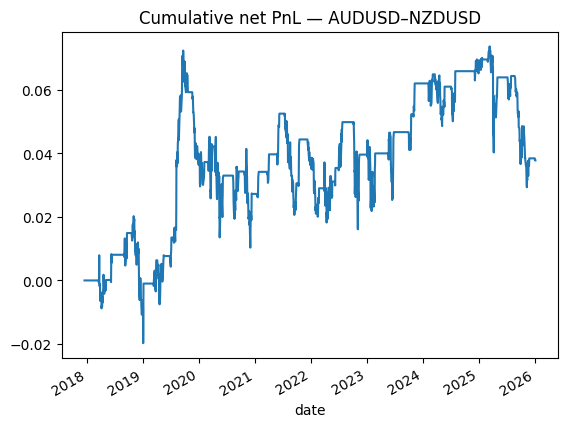

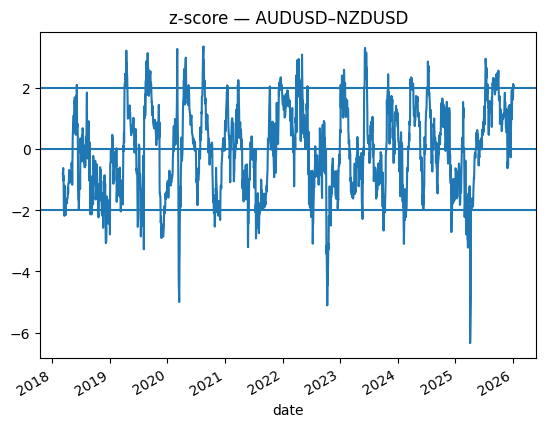

In [13]:
def plot_backtest(df: pd.DataFrame, title: str):
    (df["pnl"].cumsum()).plot(title=f"Cumulative net PnL — {title}")
    plt.show()

    df["z"].plot(title=f"z-score — {title}")
    plt.axhline(2); plt.axhline(-2); plt.axhline(0)
    plt.show()

plot_backtest(df_cnhcny, "USDCNH–USDCNY")
plot_backtest(df_audnzd, "AUDUSD–NZDUSD")


## 6) Cost sensitivity

We perform this test to find out where our strategy starts to become unprofitable. 

I find this step to be pivotal since most pairs disappear as soon as we factor in transaction cost.

Please be noted that we can adjust the costs to be as high or as low you deem appropriate

In [14]:
def cost_sweep(
    logp,
    y: str,
    x: str,
    costs_bps=(0.5, 1.0, 2.0, 3.0, 5.0, 8.0, 10.0),
    **backtest_kwargs
) -> pd.DataFrame:
    rows = []
    for c in costs_bps:
        summary, _ = pairs_backtest_single_timeline(
            logp=logp, y=y, x=x, cost_bps=float(c), **backtest_kwargs
        )
        row = {"y": y, "x": x, "cost_bps": float(c)}
        for k, v in summary.items():
            row[k] = v
        rows.append(row)

    out = pd.DataFrame(rows)
    # we order this more neatly
    cols = ["y","x","cost_bps"] + [c for c in out.columns if c not in ["y","x","cost_bps"]]
    return out[cols]


In [15]:
BT_KW = {k:v for k,v in BASE.items() if k != "cost_bps"}

cs_cnhcny = cost_sweep(
    logp, "USDCNH", "USDCNY",
    costs_bps=(0.5, 1, 2, 3, 5, 8, 10),
    **BT_KW
)
cs_cnhcny


,y,x,cost_bps,start,end,n_days,Sharpe_net,t_stat_net,avg_daily_turnover,pct_in_market,pct_|z|>entry
0,USDCNH,USDCNY,0.5,2017-12-15,2026-01-05,2087,1.974408,5.681955,0.143567,0.167226,0.068519
1,USDCNH,USDCNY,1.0,2017-12-15,2026-01-05,2087,1.882808,5.418350,0.143567,0.167226,0.068519
2,USDCNH,USDCNY,2.0,2017-12-15,2026-01-05,2087,1.695164,4.878346,0.143567,0.167226,0.068519
3,USDCNH,USDCNY,3.0,2017-12-15,2026-01-05,2087,1.502408,4.323632,0.143567,0.167226,0.068519
4,USDCNH,USDCNY,5.0,2017-12-15,2026-01-05,2087,1.105976,3.182780,0.143567,0.167226,0.068519
5,USDCNH,USDCNY,8.0,2017-12-15,2026-01-05,2087,0.502217,1.445282,0.143567,0.167226,0.068519
6,USDCNH,USDCNY,10.0,2017-12-15,2026-01-05,2087,0.107696,0.309928,0.143567,0.167226,0.068519


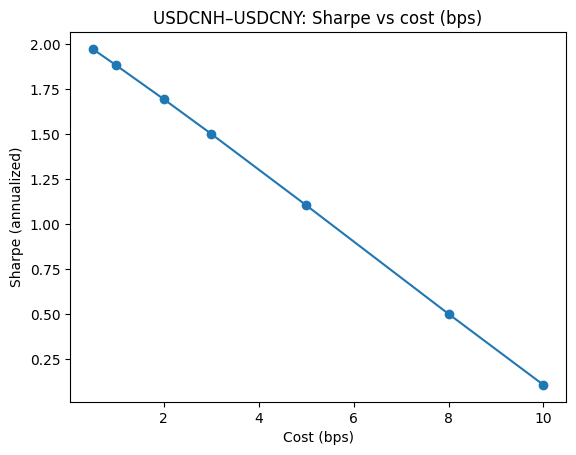

In [16]:
ax = cs_cnhcny.set_index("cost_bps")["Sharpe_net"].plot(marker="o", title="USDCNH–USDCNY: Sharpe vs cost (bps)")
ax.set_xlabel("Cost (bps)")
ax.set_ylabel("Sharpe (annualized)")
plt.show()


start                 2017-12-15
end                   2026-01-05
n_days                      2087
Sharpe_net              1.435472
t_stat_net              4.131006
avg_daily_turnover      0.369774
pct_in_market           0.153809
avg_scale               2.773856


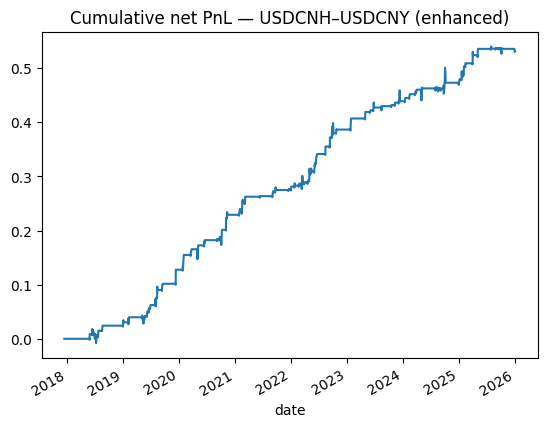

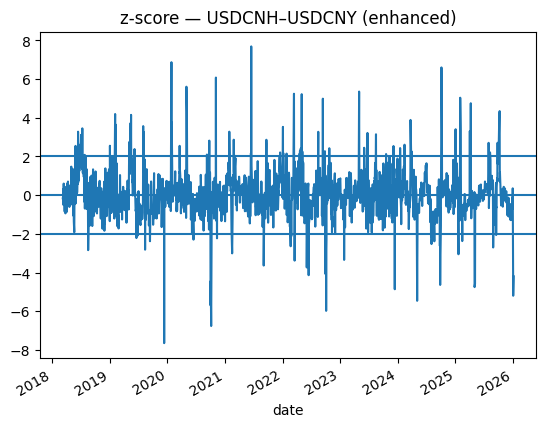

In [17]:
def pairs_backtest_enhanced(
    logp: pd.DataFrame,
    y: str,
    x: str,
    train_days: int = 252*2,
    purge_days: int = 5,
    step_days: int = 21,
    z_window: int = 60,
    entry_z: float = 2.0,
    exit_z: float = 0.5,
    cost_bps: float = 3.0,
    cooldown_days: int = 3,
    beta_ema_lambda: float = 0.8,
    vol_target_ann: float = 0.10,
    vol_window: int = 20,
    size_cap: float = 3.0,
):
    df = logp[[y, x]].dropna().copy()
    n = len(df)

    alpha = np.full(n, np.nan)
    beta  = np.full(n, np.nan)
    resid = np.full(n, np.nan)
    z     = np.full(n, np.nan)
    pos   = np.zeros(n)
    scale = np.ones(n)

    state = 0.0
    cooldown = 0
    last_refit = None
    prev_beta = None
    prev_alpha = None

    start = train_days + purge_days

    for t in range(start, n):
        # refit periodically
        if (last_refit is None) or ((t - last_refit) >= step_days):
            train = df.iloc[t - purge_days - train_days : t - purge_days]
            m = sm.OLS(train[y], sm.add_constant(train[x])).fit()
            a_hat = float(m.params.iloc[0])
            b_hat = float(m.params.iloc[1])

            if prev_beta is None:
                a, b = a_hat, b_hat
            else:
                lam = beta_ema_lambda
                a = lam * prev_alpha + (1 - lam) * a_hat
                b = lam * prev_beta  + (1 - lam) * b_hat

            prev_alpha, prev_beta = a, b
            last_refit = t

        alpha[t] = a
        beta[t]  = b

        # residual today
        yt = float(df[y].iloc[t]); xt = float(df[x].iloc[t])
        resid[t] = yt - (a + b * xt)

        # z-score using strictly past residuals
        if t >= start + z_window:
            w = resid[t - z_window : t]
            mu = np.nanmean(w)
            sd = np.nanstd(w)
            if sd > 0:
                z[t] = (resid[t] - mu) / sd

        # vol targeting based on residual changes
        if t >= start + vol_window + 2:
            dr = np.diff(resid[t - vol_window : t])
            sig_daily = np.nanstd(dr)
            if sig_daily > 0:
                sig_ann = sig_daily * np.sqrt(252)
                mult = vol_target_ann / sig_ann
                scale[t] = float(np.clip(mult, 0.0, size_cap))
            else:
                scale[t] = 1.0

        # cooldown logic
        if cooldown > 0:
            cooldown -= 1

        zz = z[t]
        if np.isnan(zz):
            pos[t] = state
            continue

        if state == 0.0:
            if cooldown == 0:
                if zz > entry_z:
                    state = -1.0
                elif zz < -entry_z:
                    state = 1.0
        else:
            if abs(zz) < exit_z:
                state = 0.0
                cooldown = cooldown_days

        pos[t] = state

    out = pd.DataFrame(
        {"alpha": alpha, "beta": beta, "resid": resid, "z": z, "pos": pos, "scale": scale},
        index=df.index
    ).dropna(subset=["beta"])

    out["wy"] = out["pos"] * out["scale"]
    out["wx"] = -out["beta"] * out["pos"] * out["scale"]

    out["ry"] = df[y].diff()
    out["rx"] = df[x].diff()

    out["gross"] = (out["wy"].shift(1) * out["ry"]) + (out["wx"].shift(1) * out["rx"])
    out["gross"] = out["gross"].fillna(0.0)

    out["turnover"] = (out["wy"].diff().abs().fillna(0.0) + out["wx"].diff().abs().fillna(0.0))
    out["cost"] = (cost_bps / 1e4) * out["turnover"]
    out["pnl"] = out["gross"] - out["cost"]

    pnl = out["pnl"].dropna()
    sharpe = np.sqrt(252) * pnl.mean() / (pnl.std(ddof=0) + 1e-12)
    tstat  = pnl.mean() / (pnl.std(ddof=0) / np.sqrt(len(pnl)) + 1e-12)

    summary = pd.Series({
        "start": pnl.index.min().date(),
        "end": pnl.index.max().date(),
        "n_days": int(len(pnl)),
        "Sharpe_net": float(sharpe),
        "t_stat_net": float(tstat),
        "avg_daily_turnover": float(out["turnover"].mean()),
        "pct_in_market": float((out["pos"].abs() > 0).mean()),
        "avg_scale": float(out["scale"].mean()),
    })
    return summary, out


# Example: run enhanced model for CNH/CNY (cost=3 bps)
ENH = dict(train_days=252*2, purge_days=5, step_days=21, z_window=60, entry_z=2.0, exit_z=0.5,
           cooldown_days=3, beta_ema_lambda=0.8, vol_target_ann=0.10, vol_window=20, size_cap=3.0, cost_bps=3.0)

s_enh, df_enh = pairs_backtest_enhanced(logp, "USDCNH", "USDCNY", **ENH)
print(s_enh.to_string())
plot_backtest(df_enh, "USDCNH–USDCNY (enhanced)")


In [18]:
# Robustness sweep (reports Sharpe at 1/3/5 bps)
grid = []
for zwin in [40, 60, 80]:
    for entry in [1.5, 2.0, 2.5]:
        for exit_ in [0.25, 0.5]:
            for cooldown in [0, 3, 5]:
                row = {"z_window": zwin, "entry": entry, "exit": exit_, "cooldown": cooldown}
                for c in [1.0, 3.0, 5.0]:
                    s, _ = pairs_backtest_enhanced(
                        logp, "USDCNH", "USDCNY",
                        z_window=zwin, entry_z=entry, exit_z=exit_,
                        cooldown_days=cooldown,
                        beta_ema_lambda=0.8,
                        vol_target_ann=0.10,
                        vol_window=20,
                        size_cap=3.0,
                        cost_bps=c
                    )
                    row[f"Sharpe@{c}bps"] = float(s["Sharpe_net"])
                    row[f"Turn@{c}bps"] = float(s["avg_daily_turnover"])
                grid.append(row)

enh_sweep = pd.DataFrame(grid).sort_values("Sharpe@3.0bps", ascending=False)
enh_sweep.head(15)


,z_window,entry,exit,cooldown,Sharpe@1.0bps,Turn@1.0bps,Sharpe@3.0bps,Turn@3.0bps,Sharpe@5.0bps,Turn@5.0bps
45,80,2.0,0.5,0,2.082343,0.376357,1.711083,0.376357,1.314556,0.376357
46,80,2.0,0.5,3,2.083676,0.360580,1.707806,0.360580,1.305060,0.360580
47,80,2.0,0.5,5,2.076256,0.334980,1.700657,0.334980,1.295941,0.334980
52,80,2.5,0.5,3,1.910164,0.246119,1.633250,0.246119,1.333558,0.246119
39,80,1.5,0.5,0,2.080899,0.561984,1.574246,0.561984,1.039506,0.561984
51,80,2.5,0.5,0,1.840005,0.255077,1.568769,0.255077,1.278064,0.255077
40,80,1.5,0.5,3,2.021498,0.499148,1.542755,0.499148,1.036218,0.499148
53,80,2.5,0.5,5,1.798884,0.226152,1.531587,0.226152,1.242042,0.226152
41,80,1.5,0.5,5,1.986043,0.444596,1.522451,0.444596,1.028879,0.444596
28,60,2.0,0.5,3,1.828881,0.369774,1.435472,0.369774,1.021251,0.369774


### 8) Saving our reports [Graphs + Tables]

This is entirely optional, but I find it helpful to have these reports ready to read

In [20]:
cs_cnhcny.to_csv(REPORTS_DIR / "cnhcny_cost_sweep.csv", index=False)

# enhanced sweep (if you ran it)
try:
    enh_sweep.to_csv(REPORTS_DIR / "cnhcny_enhanced_sweep.csv", index=False)
    print("Wrote:", (REPORTS_DIR / "cnhcny_enhanced_sweep.csv").resolve())
except NameError:
    print("enh_sweep not found (skip). Run section 7b first if you want this file.")

print("Wrote:", (REPORTS_DIR / "cnhcny_cost_sweep.csv").resolve())
print("Wrote:", (REPORTS_DIR / "cnhcny_param_sweep.csv").resolve())


Wrote: /Users/lvsreenivaas/Desktop/fx_pairs_trading/reports/cnhcny_enhanced_sweep.csv
Wrote: /Users/lvsreenivaas/Desktop/fx_pairs_trading/reports/cnhcny_cost_sweep.csv
Wrote: /Users/lvsreenivaas/Desktop/fx_pairs_trading/reports/cnhcny_param_sweep.csv
